Surveying data from other groups of the BSMN consortium that could be used to extend the control group of our schizophrenia study.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
from IPython.core.display import HTML
import pandas as pd
import re
import bsmnwgs
import attila_utils

Welcome, Attila Jones!



In [2]:
synIDs = {'Gleeson': {'genomics_subject02': ['syn20570442'], 'nichd_btb02': ['syn20635486']},
'Moran': {'genomics_subject02': ['syn18381371'], 'nichd_btb02': ['syn18381373']},
'Pevsner': {'genomics_subject02': ['syn18433975'], 'nichd_btb02': ['syn18433976']},
'Vaccarino': {'genomics_subject02': ['syn12031220'], 'nichd_btb02': ['syn12031303']},
'Walsh': {'genomics_subject02': ['syn17227559'], 'nichd_btb02': ['syn17227560']},
'Weinberger': {'genomics_subject02': ['syn16797371', 'syn21570709'], 'nichd_btb02': ['syn16797373', 'syn21570710']}}

In [3]:
def get_manifest_type(mtype):
    manifests = dict()
    for PI, d in synIDs.items():
        m = bsmnwgs.get_manifests(synids=d[mtype], project=PI, maniftype=mtype)
        manifests.update({PI: m})
    return(manifests)

subject02s = get_manifest_type(mtype='genomics_subject02')
btb02s = get_manifest_type(mtype='nichd_btb02')

## Inspecting manifests

Let's print the tail of both types of manifest for each PI!

In [4]:
bcols = ['subjectkey', 'disorder', 'sample_id_original', 'celltype', 'br_reg']
scols = ['subjectkey', 'phenotype', 'sample_description']
for PI in btb02s.keys():
    print(PI)
    m = btb02s[PI]
    display(HTML(m.tail().loc[:, bcols].to_html()))
    #print('\n')
    m = subject02s[PI]
    display(HTML(m.tail().loc[:, scols].to_html()))
    print('\n')

Gleeson


,subjectkey,disorder,sample_id_original,celltype,br_reg
20,NDARED547KHB,NaN,6102810951,NaN,NaN
21,NDARED547KHB,NaN,1269270133,NaN,NaN
22,NDARED547KHB,NaN,9244521147,NaN,prefrontal cortex
23,NDARED547KHB,NaN,6932213467,NaN,occipital cortex
24,NDARED547KHB,NaN,9492138871,NaN,NaN


,subjectkey,phenotype,sample_description
0,NDARED547KHB,Global Geriatric Decline,brain




Moran


,subjectkey,disorder,sample_id_original,celltype,br_reg
5,NDARGV580CWV,Control,Br5415,NaN,cerebellum
6,NDAREU049CBP,Control,Br5459,NaN,cerebellum
7,NDARRX596NEB,Schizophrenia,Br5475,NaN,cerebellum
8,NDARRH300TMK,Schizophrenia,Br5485,NaN,cerebellum
9,NDARRY635XWH,Schizophrenia,Br5488,NaN,cerebellum


,subjectkey,phenotype,sample_description
5,NDARGV580CWV,Control,cerebellum
6,NDAREU049CBP,Control,cerebellum
7,NDARRX596NEB,Schizophrenia,cerebellum
8,NDARRH300TMK,Schizophrenia,cerebellum
9,NDARRY635XWH,Schizophrenia,cerebellum




Pevsner


,subjectkey,disorder,sample_id_original,celltype,br_reg
24,NDAR_INV51J7Y022,No Diagnosis on Axis I,Br2080,NaN,NaN
25,NDAR_INVY99VUP0G,Bipolar I MRE Manic Psychotic,Br2238,NaN,NaN
26,NDAR_INV9VKLJAM4,No Diagnosis on Axis I,Br2257,NaN,NaN
27,NDAR_INV9VE3YNDH,Bipolar I MRE Depressed Psychotic,Br2269,NaN,NaN
28,NDAR_INV6RXY2HC3,No Diagnosis on Axis I,Br2288,NaN,NaN


,subjectkey,phenotype,sample_description
24,NDAR_INV51J7Y022,No Diagnosis on Axis I,frontal cortex
25,NDAR_INVY99VUP0G,"Bipolar I MRE Manic Psychotic, Alcohol Abuse",frontal cortex
26,NDAR_INV9VKLJAM4,No Diagnosis on Axis I,frontal cortex
27,NDAR_INV9VE3YNDH,"Bipolar I MRE Depressed Psychotic, Opioid Dependence",frontal cortex
28,NDAR_INV6RXY2HC3,No Diagnosis on Axis I,frontal cortex




Vaccarino


,subjectkey,disorder,sample_id_original,celltype,br_reg
22,NDAR_INVEUAH999H,Normal,7087-CDPT,bulk,putamen_caudate
23,NDAR_INV260ECBT8,Normal,5813-BA6FA,bulk,cortex
24,NDAR_INV260ECBT8,Normal,5813-CDPT,bulk,putamen_caudate
25,NDAR_INVRD5V510Y,Normal,3932-CDPT,bulk,putamen_caudate
26,NDAR_INVZFPD5Z6V,Normal,5873-CDPT,bulk,putamen_caudate


,subjectkey,phenotype,sample_description
11,NDAR_INVDNRXJ41X,control,brain
12,NDAR_INVEUAH999H,control,brain
13,NDAR_INV260ECBT8,control,brain
14,NDAR_INVRD5V510Y,control,brain
15,NDAR_INVZFPD5Z6V,control,brain




Walsh


,subjectkey,disorder,sample_id_original,celltype,br_reg
74,NDAR_INVMR608HT9,NaN,UMB5939F,saliva,NaN
75,NDAR_INVLA347WBF,NaN,UMB5939M,saliva,NaN
76,NDARYX624FEY,NaN,UMB797,frontal cortex,NaN
77,NDAR_INVTN706HNW,NaN,UMB818,frontal cortex,NaN
78,NDAR_INVVH788TM6,NaN,UMB914,frontal cortex,NaN


,subjectkey,phenotype,sample_description
74,NDAR_INVMR608HT9,Normal,saliva
75,NDAR_INVLA347WBF,Normal,saliva
76,NDARYX624FEY,Autism,frontal cortex
77,NDAR_INVTN706HNW,Normal,frontal cortex
78,NDAR_INVVH788TM6,Normal,frontal cortex




Weinberger


,subjectkey,disorder,sample_id_original,celltype,br_reg
82,NDARRT904HJE,NaN,Br5660_tripleneg,NaN,DLPFC
83,NDARUB276TVW,NaN,Br5888_MBPpos,NaN,DLPFC
84,NDARUB276TVW,NaN,Br5888_SLC17A7pos,NaN,DLPFC
85,NDARUB276TVW,NaN,Br5888_SNAP25pos,NaN,DLPFC
86,NDARUB276TVW,NaN,Br5888_tripleneg,NaN,DLPFC


,subjectkey,phenotype,sample_description
17,NDARUG441NXW,Schizophrenia,brain
18,NDARRX596NEB,Schizophrenia,brain
19,NDARRY635XWH,Schizophrenia,brain
20,NDARRT904HJE,Control,brain
21,NDARUB276TVW,Schizophrenia,brain


## Number of control samples
### The Chess data set

In [5]:
nctr = {'Chess': 25}
ncas = {'Chess': 61}

### The Gleeson data set

In [6]:
nctr.update({'Gleeson': 0})
ncas.update({'Gleeson': 1})

### The Moran data set
This consists of only cerebellar samples

In [7]:
all(btb02s['Moran']['br_reg'] == 'cerebellum')
nctr.update({'Moran (cerebellum)': 5})
ncas.update({'Moran (cerebellum)': 5})

### The Pevsner data set
Number of control individuals

In [8]:
nctr.update({'Pevsner (WES)': sum((subject02s['Pevsner']['phenotype'] == 'No Diagnosis on Axis I'))})
ncas.update({'Pevsner (WES)': sum((subject02s['Pevsner']['phenotype'] != 'No Diagnosis on Axis I'))})

### The Vaccarino data set

In [9]:
vb = btb02s['Vaccarino']
nctr.update({'Vaccarino': sum((vb['disorder'] == 'Normal') & (vb['br_reg'] == 'cortex'))})
ncas.update({'Vaccarino': sum((vb['disorder'] != 'Normal') & (vb['br_reg'] == 'cortex'))})

### The Walsh data set

In [10]:
wab = btb02s['Walsh']
was = subject02s['Walsh']

def count_walsh(phenotype='Normal'):
    group = was.loc[was['phenotype'] == phenotype, 'subjectkey']
    rows = wab['subjectkey'].isin(group) & (wab['celltype'] == 'frontal cortex')
    return(sum(rows))

#controls = was.loc[was['phenotype'] == 'Normal', 'subjectkey']
#rows = wab['subjectkey'].isin(controls) & (wab['celltype'] == 'frontal cortex')
nctr.update({'Walsh': count_walsh('Normal')})
ncas.update({'Walsh': count_walsh('Autism')})

### The Weinberger data set

Samples from the DLPFC were further classified according to three markers:

* [MBP](https://en.wikipedia.org/wiki/Myelin_basic_protein), myelin basic protein
* [SLC17A7](https://en.wikipedia.org/wiki/Vesicular_glutamate_transporter_1), vesicular glutamate transporter 1
* [SNAP25](https://en.wikipedia.org/wiki/SNAP25), Synaptosomal-Associated Protein, 25kDa

In [11]:
web = btb02s['Weinberger']
wes = subject02s['Weinberger']

def get_positives(marker='MBP'):
    matchstr = '^.*' + marker + 'pos'
    positives = [bool(re.match(matchstr, x)) for x in web['sample_id_original']]
    return(positives)

def count_weinberger(phenotype='Control', marker='MBP'):
    controls = wes.loc[wes['phenotype'] == phenotype, 'subjectkey']
    rows = web['subjectkey'].isin(controls) & (web['br_reg'] == 'DLPFC')
    return(sum(rows & get_positives(marker)))

nctr.update({'Weinberger_MBP': count_weinberger('Control', 'MBP')})
nctr.update({'Weinberger_SLC17A7': count_weinberger('Control', 'SLC17A7')})
nctr.update({'Weinberger_SNAP25': count_weinberger('Control', 'SNAP25')})

ncas.update({'Weinberger_MBP': count_weinberger('Schizophrenia', 'MBP')})
ncas.update({'Weinberger_SLC17A7': count_weinberger('Schizophrenia', 'SLC17A7')})
ncas.update({'Weinberger_SNAP25': count_weinberger('Schizophrenia', 'SNAP25')})

['named-figure/bsmn-case-control-ssizes.png',
 'named-figure/bsmn-case-control-ssizes.pdf']

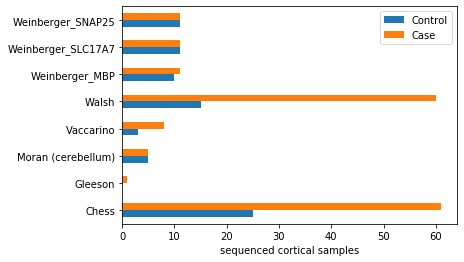

In [12]:
df = pd.DataFrame({'Control': nctr, 'Case': ncas})
# remove the Pevsner data set since it's WES and not WGS
df = df.loc[df.index != 'Pevsner (WES)']
fig, ax = plt.subplots(figsize=(6, 4))
ax = df.plot(kind='barh', ax=ax)
ax.set_xlabel('sequenced cortical samples')
attila_utils.savefig(fig, 'bsmn-case-control-ssizes')

## Summary

The tails (above) and the entire contents of the manifests reveal that

* The Gleeson data set may be excluded because it's based on a single individual with Global Geriatric Decline
* The Moran data set is also to be excluded because it's only from cerebellar samples
* The Pevsner data set contains 10 frontal cortex samples from control individuals
* The Walsh data set has 15 frontal cortex samples, each from a distinct control individual
* The Weinberger DLPFC control samples are marked by one of three neuronal markers (or are marked as triple negative).  **TODO**: Find out which of those samples might be useful! 

In [13]:
%connect_info

{
  "shell_port": 33381,
  "iopub_port": 44225,
  "stdin_port": 44467,
  "control_port": 57993,
  "hb_port": 37143,
  "ip": "127.0.0.1",
  "key": "07fef17c-b6a9da8331904a6656bbd8af",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-391b6fe8-d9a1-4372-9a1f-08b383eaea2a.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
